# BL5.3.1 Pilatus controls using EPICS
June 2023, awojdyla@lbl.gov

This notebook demonstrates how to use python scripting to trigger a Pilatus 1M acquisition and perform energy scans.
It is based on the previous notebook "20221221 EPICS pilatus hexapod" which contains an additional layer of data analysis


### Load the necessay packages

In [3]:
import epics

import numpy as np
from PIL import Image

### Create an instance of the Pilatus camera
We create an EPICS object that will allow to change the settings of the camera without using Process Variable (PV) neames

In [5]:

## doesn't work anymore????
#pilatus_cam = epics.devices.AD_Camera('13PIL1:cam1:')



# alternative -- triggering an acquisition using the EPICS protocol without creating a camera object
epics.caput('13PIL1:cam1:Acquire',1)

CA.Client.Exception...............................................
    Context: "Channel: "13PIL1:cam1:Acquire", Connecting to: 131.243.80.244:5064, Ignored: 192.168.10.75:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Jun 29 2023 14:31:22.012589107
..................................................................


1

In [6]:
filename = 'sample_20230629'
# changing filename using a PV...
epics.caput('13PIL1:cam1:FileName', filename)

CA.Client.Exception...............................................


1

    Context: "Channel: "13PIL1:cam1:FileName", Connecting to: ppu088.dhcp.lbl.gov:5064, Ignored: 192.168.10.75:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Jun 29 2023 14:31:57.455471453
..................................................................


### Acquisition settings

In [7]:
pilatus_cam.AcquireTime = 0.5  # exposure time
pilatus_cam.TriggerMode = 0    # put trigger mode to Internal


NameError: name 'pilatus_cam' is not defined

### Collect an image

In [ ]:
pilatus_cam.Acquire = 1        # collect an image

### Get the name of the last file (for convenience)

In [8]:
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
#last_filename = bytes(last_filename_ascii).decode()
last_filename = (''.join(chr(i) for i in last_filename_ascii))[:-1] #alternative
last_filename

CA.Client.Exception...............................................
    Context: "Channel: "13PIL1:cam1:FullFileName_RBV", Connecting to: ppu088.dhcp.lbl.gov:5064, Ignored: 192.168.10.75:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Jun 29 2023 14:32:09.476417599
..................................................................


'/mnt/data531/sample_2_024.tif'

### read the last image 

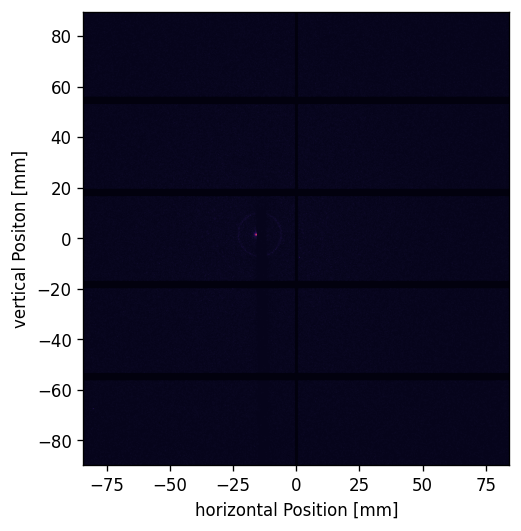

In [9]:
# read the image
im_tiff = Image.open(last_filename)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
# extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

### Live Feed

/tmp/ipykernel_3460103/699793081.py:27: RuntimeWarning: invalid value encountered in power
  plt.imshow(im_np**0.2, extent=extent, cmap = 'inferno')


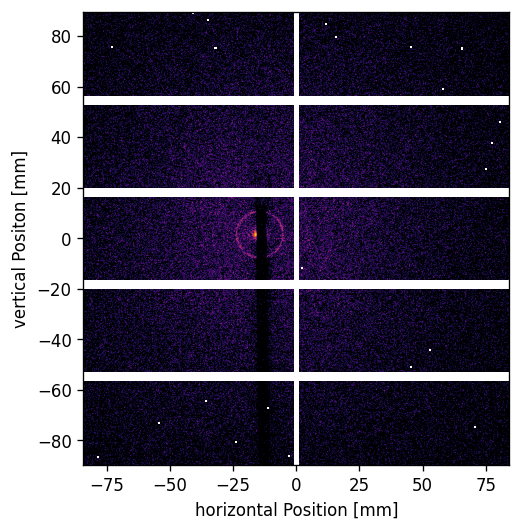

In [24]:

epics.caput('13PIL1:cam1:Acquire',1)

last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
#last_filename = bytes(last_filename_ascii).decode()
last_filename = (''.join(chr(i) for i in last_filename_ascii))[:-1] #alternative
last_filename

# read the image
im_tiff = Image.open(last_filename)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
# extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels
  
plt.imshow(im_np**0.2, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [10]:
from time import sleep as time_sleep

### Move the monochromator

#### Read teh mono position
(before we mess up anyything)

In [12]:
# connect to the monochromator
pv_name_mono = 'bl531_xps1:mono_angle_deg'
# print the current mono position
print(epics.caget(pv_name_mono))

# not used 
theta_ref_deg = 28.7 # good know position of the mono


24.3


CA.Client.Exception...............................................
    Context: "Channel: "bl531_xps1:mono_angle_deg", Connecting to: 131.243.80.239:43297, Ignored: 192.168.10.123:43297"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Jun 29 2023 14:33:24.511353653
..................................................................


In [103]:
# set the mono to a new position
theta_deg = 28.7
epics.caput(pv_name_mono, theta_deg)
time_sleep(1)
print(epics.caget(pv_name_mono))

28.7


### Make an acquisition loop

In [17]:
# mono start position
theta0_deg = 25
# mono anfular increments
dtheta_deg = 0.1
# number of points
N_s = 3

theta_deg = np.zeros(N_s)
filenames = ()
images = ()
# move to first position
epics.caput(pv_name_mono, theta0_deg)
time_sleep(2)

# loop
for i_s in np.arange(N_s):
    theta_deg[i_s] = theta0_deg + dtheta_deg*i_s
    epics.caput(pv_name_mono, theta_deg[i_s])
    # equivalently:
    
    epics.caput('13PIL1:cam1:Acquire',1)
    # pilatus_cam.Acquire = 1
    time_sleep(2)
    
    

    last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
    #last_filename = bytes(last_filename_ascii).decode()
    last_filename = (''.join(chr(i) for i in last_filename_ascii))[:-1] #alternative
    filenames += (last_filename,)

    img = img = np.squeeze(np.array(Image.open(last_filename).getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))
    images += (img,)
    print('mono position: %1.3f deg' % epics.caget(pv_name_mono) + 'pilatus filename: ' + last_filename)

mono position: 25.000 degpilatus filename: /mnt/data531/sample_20230629_028.tif
mono position: 25.100 degpilatus filename: /mnt/data531/sample_20230629_029.tif
mono position: 25.200 degpilatus filename: /mnt/data531/sample_20230629_030.tif


### Display the data

/tmp/ipykernel_3460103/879103019.py:16: RuntimeWarning: invalid value encountered in power
  plt.imshow(im_np**0.2, extent=extent, cmap = 'inferno')


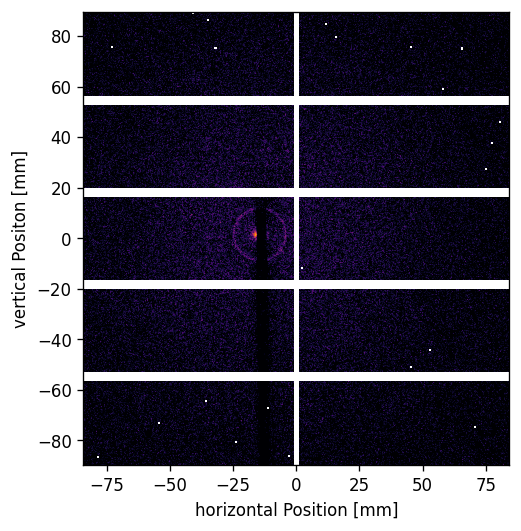

In [20]:
im_np = images[0]
# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
# extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels

plt.imshow(im_np**0.2, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()